# 4b Walk Through Analyses with causal continuous confound
prepare imports & paths

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from julearn.transformers.confounds import DataFrameConfoundRemover
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib as mpl
from matplotlib.lines import Line2D
from leakconfound.analyses.utils import save_paper_val
from leakconfound.plotting import mm_to_inch
from leakconfound.transformers import Shuffle
from sciplotlib import style

from myst_nb import glue

base_save_paper = "./paper_val/"

mpl.style.use(style.get_style('nature-reviews'))
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('axes', labelsize=12, titlesize=12)
mpl.rc('figure', dpi=300)
mpl.rc('figure.subplot', wspace=mm_to_inch(4), hspace=mm_to_inch(7))
mpl.rc('lines', linewidth=1)

colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488',
          '#F39B7F', '#8491B4', '#91D1C2FF', '#DC0000',
          '#7E6148', '#B09C85']
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]

simulate data

In [2]:
np.random.seed(7329847)

confound = np.array([0]*1000 + [1]*1000)
feat = np.append(np.append(np.random.normal(-1, scale=.5, size=500),
                 np.random.normal(-5, .5, size=500)),
                 np.random.normal(scale=.5, size=1000)
                 )
target = np.random.normal(scale=.5, size=2000) + confound
df = pd.DataFrame({'conf__:type:__confound': confound,
                   'feat': feat, "target": target}
                  ).sample(frac=1).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.target, test_size=.3)

show relationships in data

In [3]:
bisarial_conf_y = stats.pointbiserialr(df["conf__:type:__confound"], df["target"])
print("Pointbiserialr confound target ", bisarial_conf_y)

save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "pointbiserialr_conf_target.txt",
               bisarial_conf_y[0]
               )
bisarial_conf_feat = stats.pointbiserialr(df["conf__:type:__confound"], df["feat"])
print("Pointbiserialr confound feat ", bisarial_conf_feat)

save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "pointbiserialr_conf_feat.txt",
               bisarial_conf_feat[0]
               )
pearson_feat_target = stats.pearsonr(df["feat"], df["target"])
print("Pearsonr feat target:", pearson_feat_target)
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "pearsonr_feat_target.txt",
               pearson_feat_target[0]
               )

save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "p_pointbiserialr_conf_target.txt",
               bisarial_conf_y[1], precision=3
               )
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "p_pointbiserialr_conf_feat.txt",
               bisarial_conf_feat[1],  precision=3
               )
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "relations", "p_pearsonr_feat_target.txt",
               pearson_feat_target[1],  precision=3
               )

Pointbiserialr confound target  PointbiserialrResult(correlation=0.711360122352378, pvalue=2.531213268070299e-308)
Pointbiserialr confound feat  PointbiserialrResult(correlation=0.7112491183265328, pvalue=3.4839683337234963e-308)
Pearsonr feat target: (0.5081897828555303, 8.476726924677376e-132)


Shuffle and Confound Remove Data

In [4]:
shuffler = Shuffle().fit(X_train, y_train)
X_train_shuffled = shuffler.transform(X_train)
X_test_shuffled = shuffler.transform(X_test)

X_train_shuffled["conf__:type:__confound"] = X_train["conf__:type:__confound"]
X_test_shuffled["conf__:type:__confound"] = X_test["conf__:type:__confound"]


CR = DataFrameConfoundRemover().fit(X_train, y_train)
CR_shuffled = DataFrameConfoundRemover().fit(X_train_shuffled, y_train)

X_train_CR = CR.transform(X_train)
X_test_CR = CR.transform(X_test)
X_train_raw = X_train.drop(columns=["conf__:type:__confound"])
X_test_raw = X_test.drop(columns=["conf__:type:__confound"])


X_train_shuffled_CR = CR_shuffled.transform(X_train_shuffled)
X_test_shuffled_CR = CR_shuffled.transform(X_test_shuffled)

X_train_shuffled_raw = X_train_shuffled.drop(columns=["conf__:type:__confound"])
X_test_shuffled_raw = X_test_shuffled.drop(columns=["conf__:type:__confound"])

model and score data using DT Regressor

In [5]:
dt_no_CR = DecisionTreeRegressor(max_depth=2).fit(X_train_raw, y_train)
dt_CR = DecisionTreeRegressor(max_depth=2).fit(X_train_CR, y_train)
dt_shuffled_no_CR = DecisionTreeRegressor(max_depth=2).fit(X_train_shuffled_raw, y_train)
dt_shuffled_CR = DecisionTreeRegressor(max_depth=2).fit(X_train_shuffled_CR, y_train)

dt_score_no_CR = dt_no_CR.score(X_test_raw, y_test)
dt_score_CR = dt_CR.score(X_test_CR, y_test)
dt_score_shuffled_no_CR = dt_shuffled_no_CR.score(X_test_shuffled_raw, y_test)
dt_score_shuffled_CR = dt_shuffled_CR.score(X_test_shuffled_CR, y_test)

print(f"{dt_score_no_CR = }")
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "not_removed", "dt.txt",
               dt_score_no_CR
               )

print(f"{dt_score_CR = }")
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "removed", "dt.txt",
               dt_score_CR)


print(f"{dt_score_shuffled_no_CR = }")
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "not_removed", "dt_shuffled.txt",
               dt_score_shuffled_no_CR
               )

print(f"{dt_score_shuffled_CR = }")
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "removed", "dt_shuffled.txt",
               dt_score_shuffled_CR)

dt_score_no_CR = 0.28774618500928395
dt_score_CR = 0.4247860016488524
dt_score_shuffled_no_CR = 0.0004774852234581406
dt_score_shuffled_CR = -0.0065182826747101075


Analyzes on Xhat

In [6]:
X_hat_train = CR.models_confound_.iloc[0].predict(
    X_train[["conf__:type:__confound"]]).reshape(-1, 1)
X_hat_test = CR.models_confound_.iloc[0].predict(X_test[["conf__:type:__confound"]]).reshape(-1, 1)
X_CR_test = CR.transform(X_test)

dt_xhat = DecisionTreeRegressor(max_depth=2).fit(X_hat_train, y_train)
X_hat_score = dt_xhat.score(X_hat_test, y_test)

print(f"{X_hat_score = }")
save_paper_val(base_save_paper,
               "walk_through_continuous",
               "Xhat", "dt.txt",
               X_hat_score
               )

X_hat_score = 0.5052765711928848


plotting of not removed

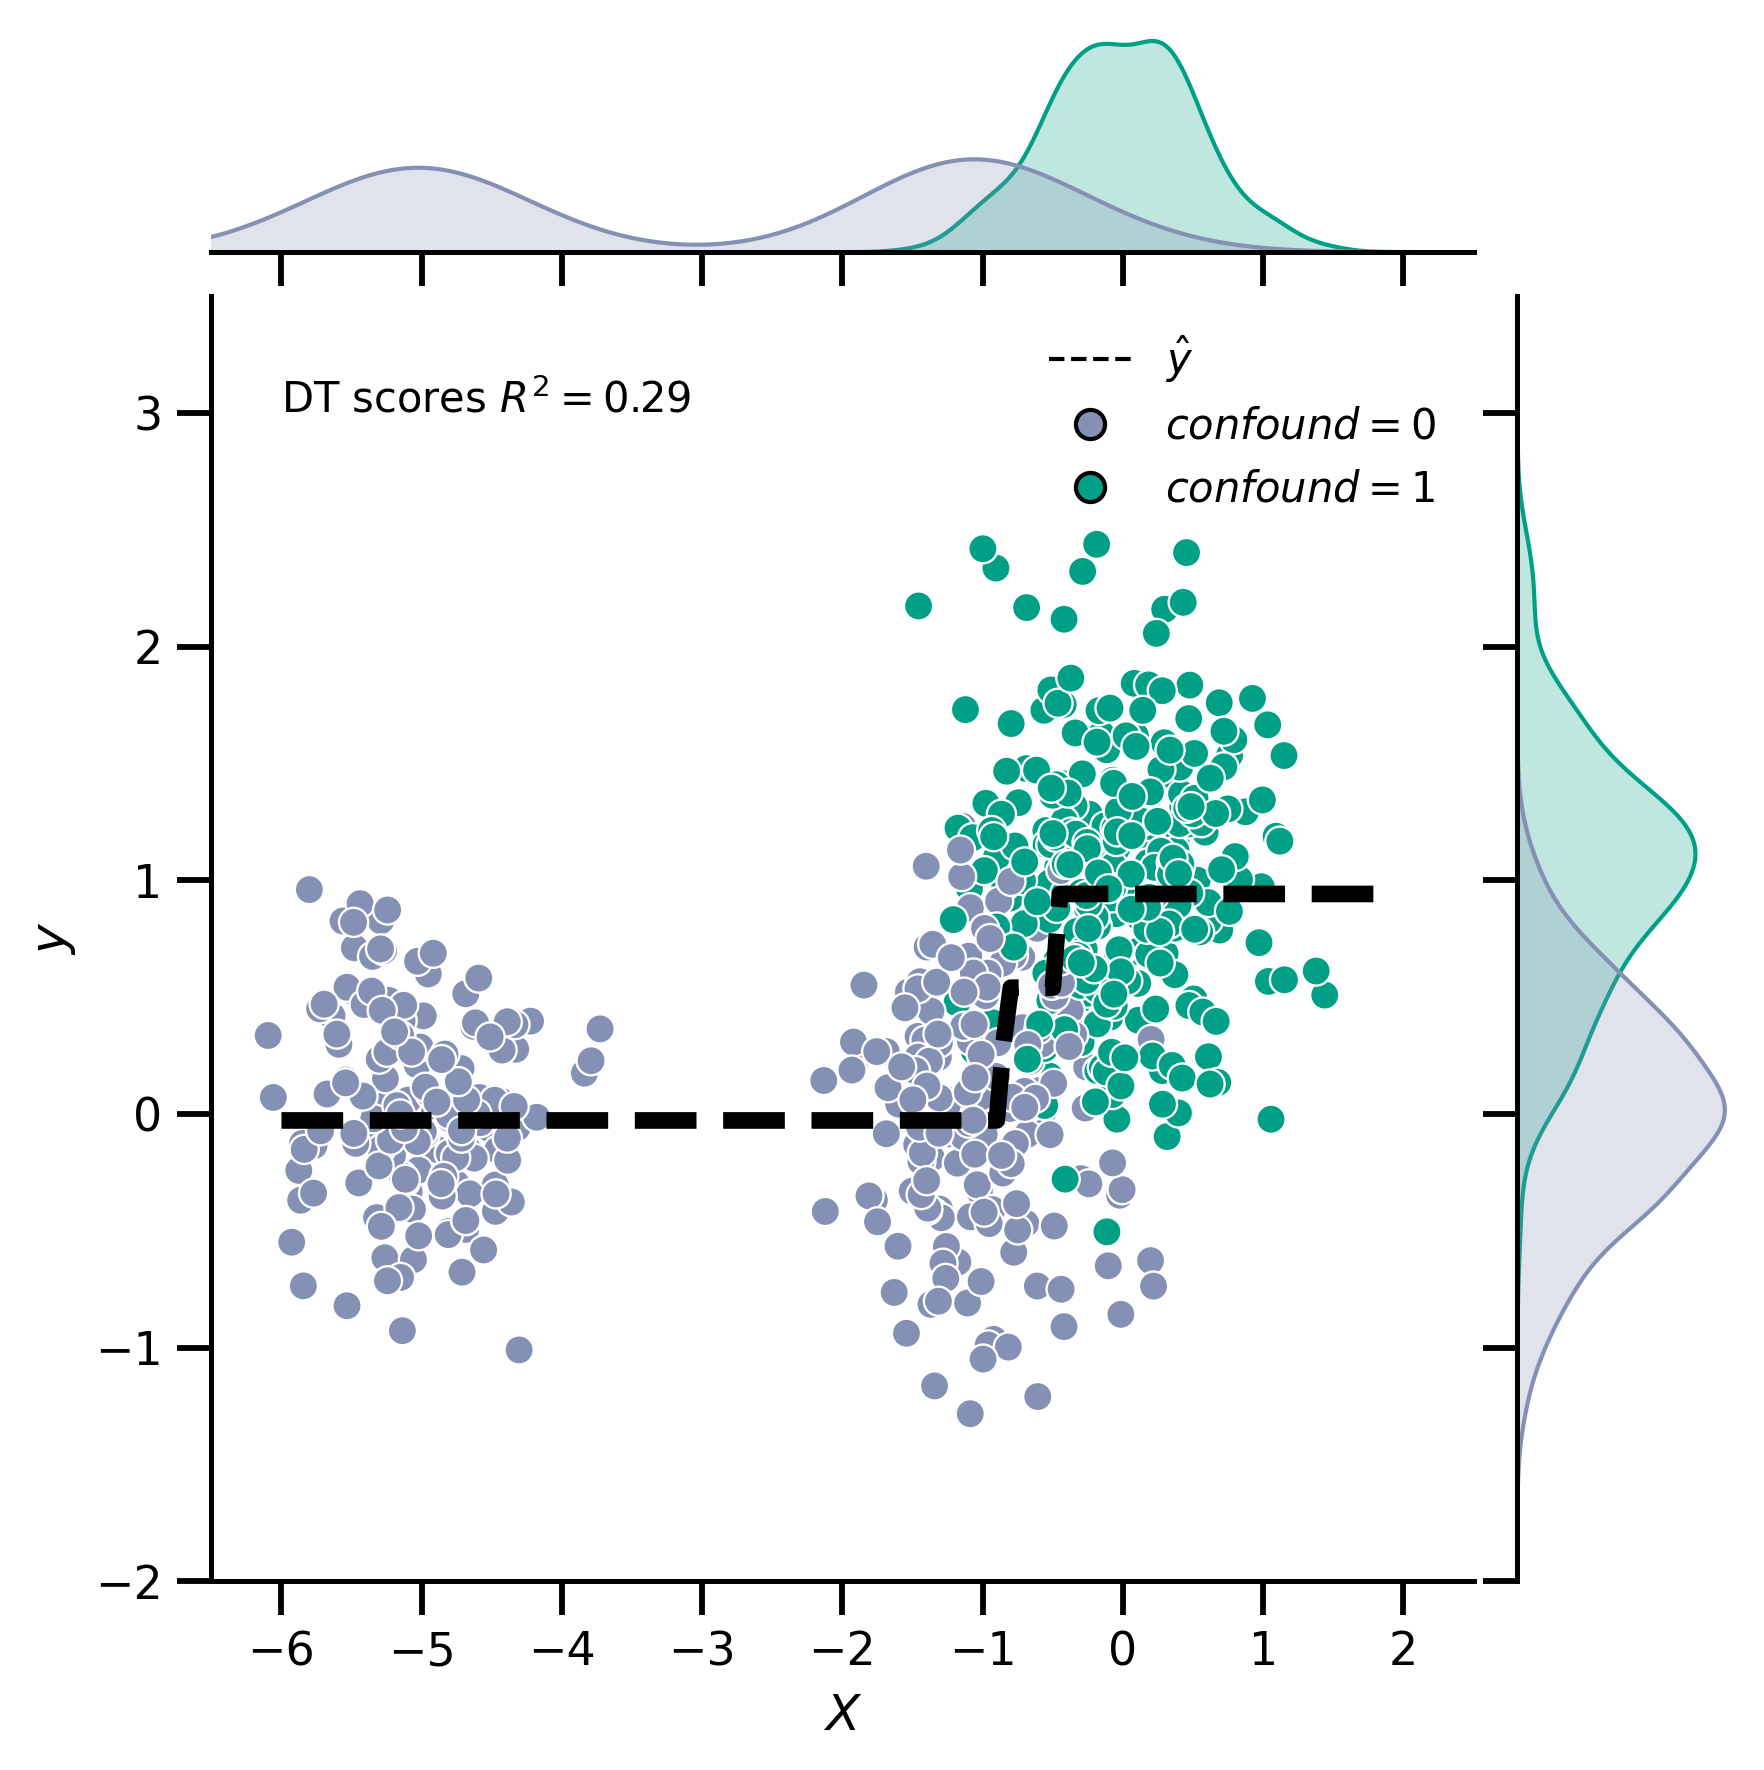

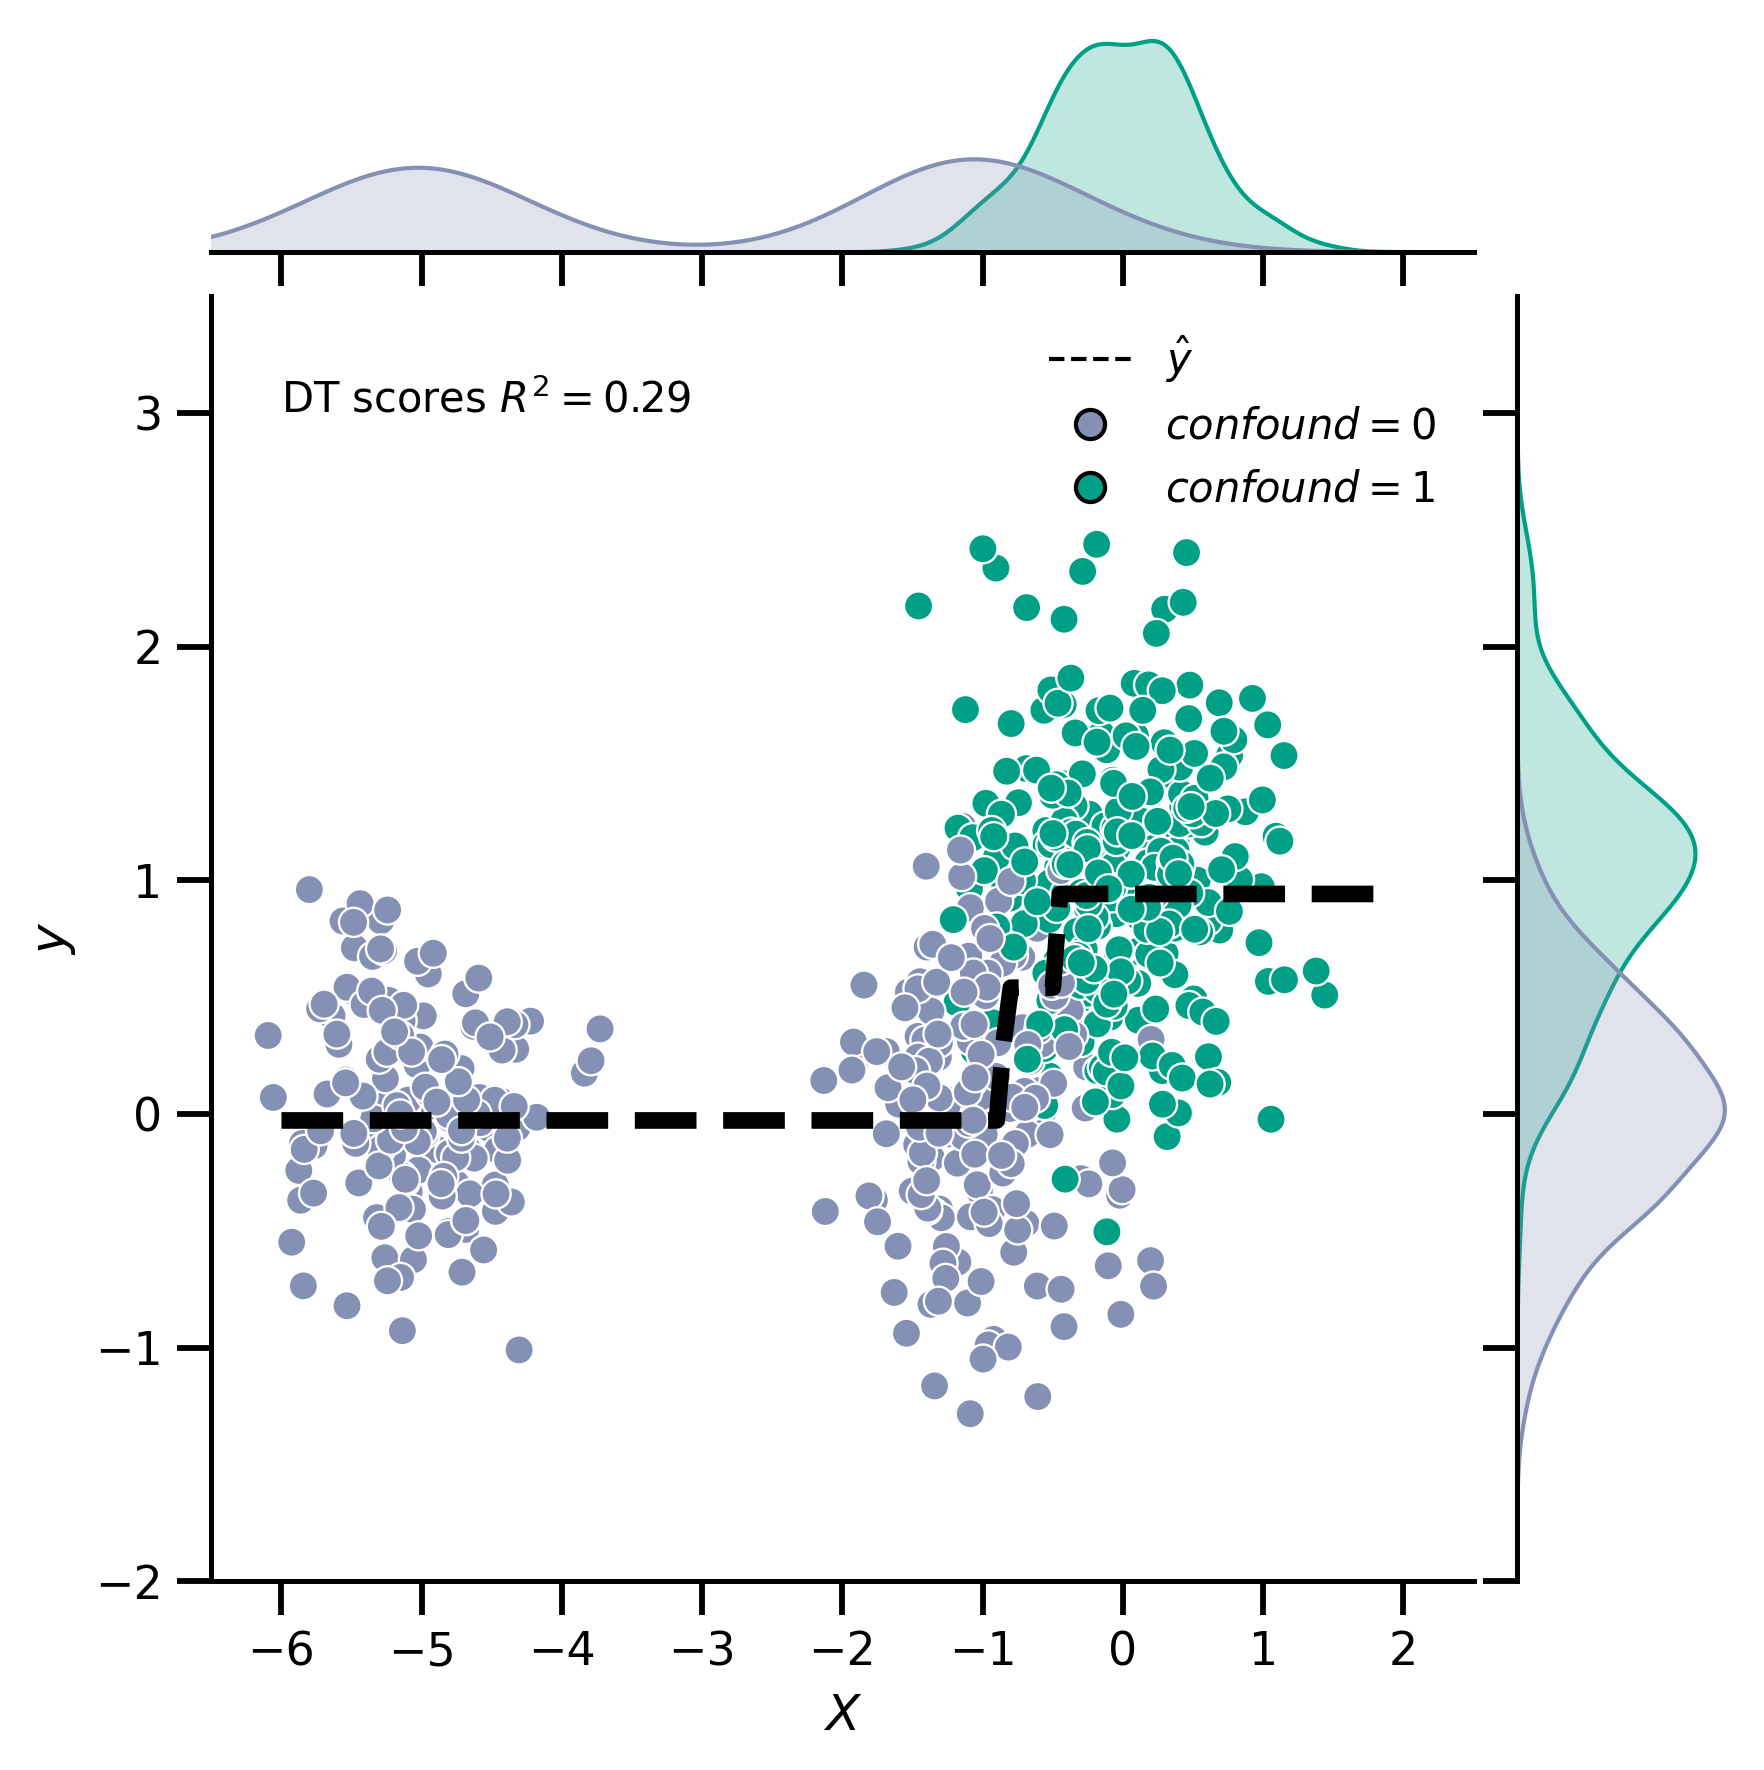

In [7]:
df_test_plot = pd.DataFrame(dict(
    feat=X_test_raw["feat"],
    confound=X_test["conf__:type:__confound"],
    target=y_test,
    feat_removed=X_CR_test.values.reshape(-1),
    feat_predicted=X_hat_test.reshape(-1)
))


g = sns.jointplot(x="feat", y="target", hue="confound",
                  hue_order=[0, 1],
                  palette=sns.color_palette([purple, green]),
                  data=df_test_plot, legend=False)

X = np.arange(-6, 2, .05)
pred = dt_no_CR.predict(X.reshape(-1, 1))
data = pd.DataFrame(dict(pred=pred, X=X))
sns.lineplot(x="X", y="pred", ax=g.ax_joint, data=data, lw=4, color="k")

g.ax_joint.lines[0].set_linestyle("--")

g.ax_joint.set_xlabel("$X$")
g.ax_joint.set_ylabel("$y$")
g.ax_joint.set_xlim(-6.5, 2.5)
g.ax_joint.set_ylim(-2, 3.5)
g.ax_joint.text(-6, 3, f"DT scores $R^2 = {dt_score_no_CR:.2}$")

handles = [
    Line2D([0], [0], color="k", lw=1, ls="--", label=r"$\hat{y}$"),
    Line2D([0], [0], marker='o', lw=0, color=purple, label='$confound=0$'),
    Line2D([0], [0], marker='o', lw=0, color=green, label='$confound=1$')

]

g.ax_joint.legend(handles=handles, loc="upper right")
g.savefig(f"{base_save_paper }/dt_sim_confound_raw.svg")

glue("no_rm", g.fig, display=False)


plotting of removed

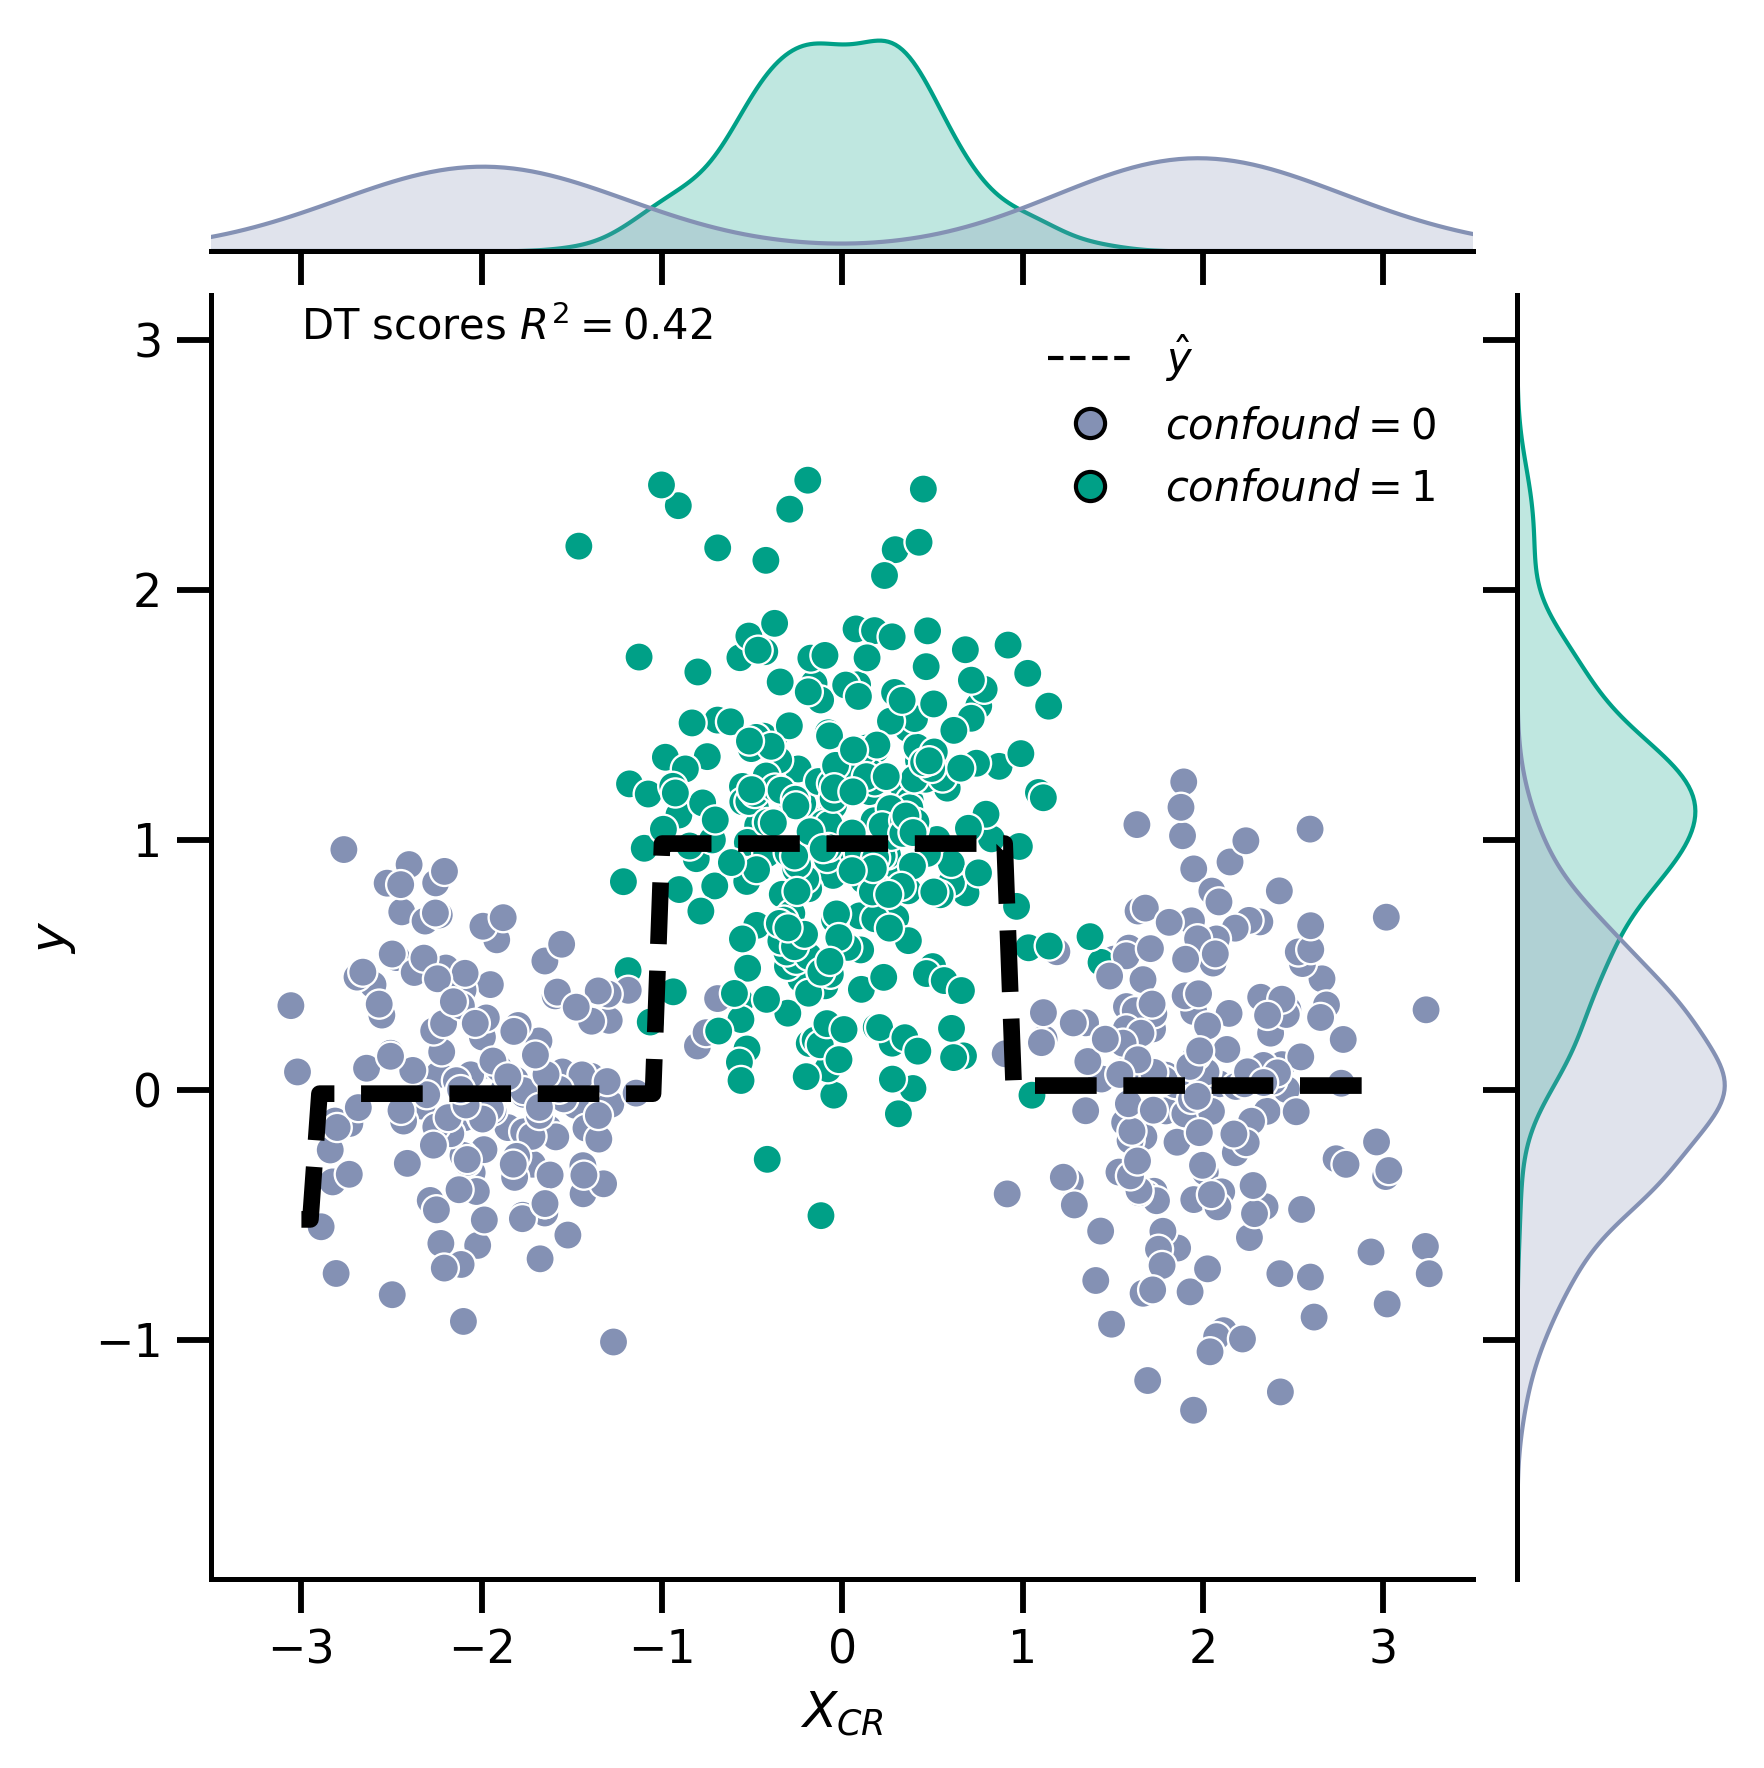

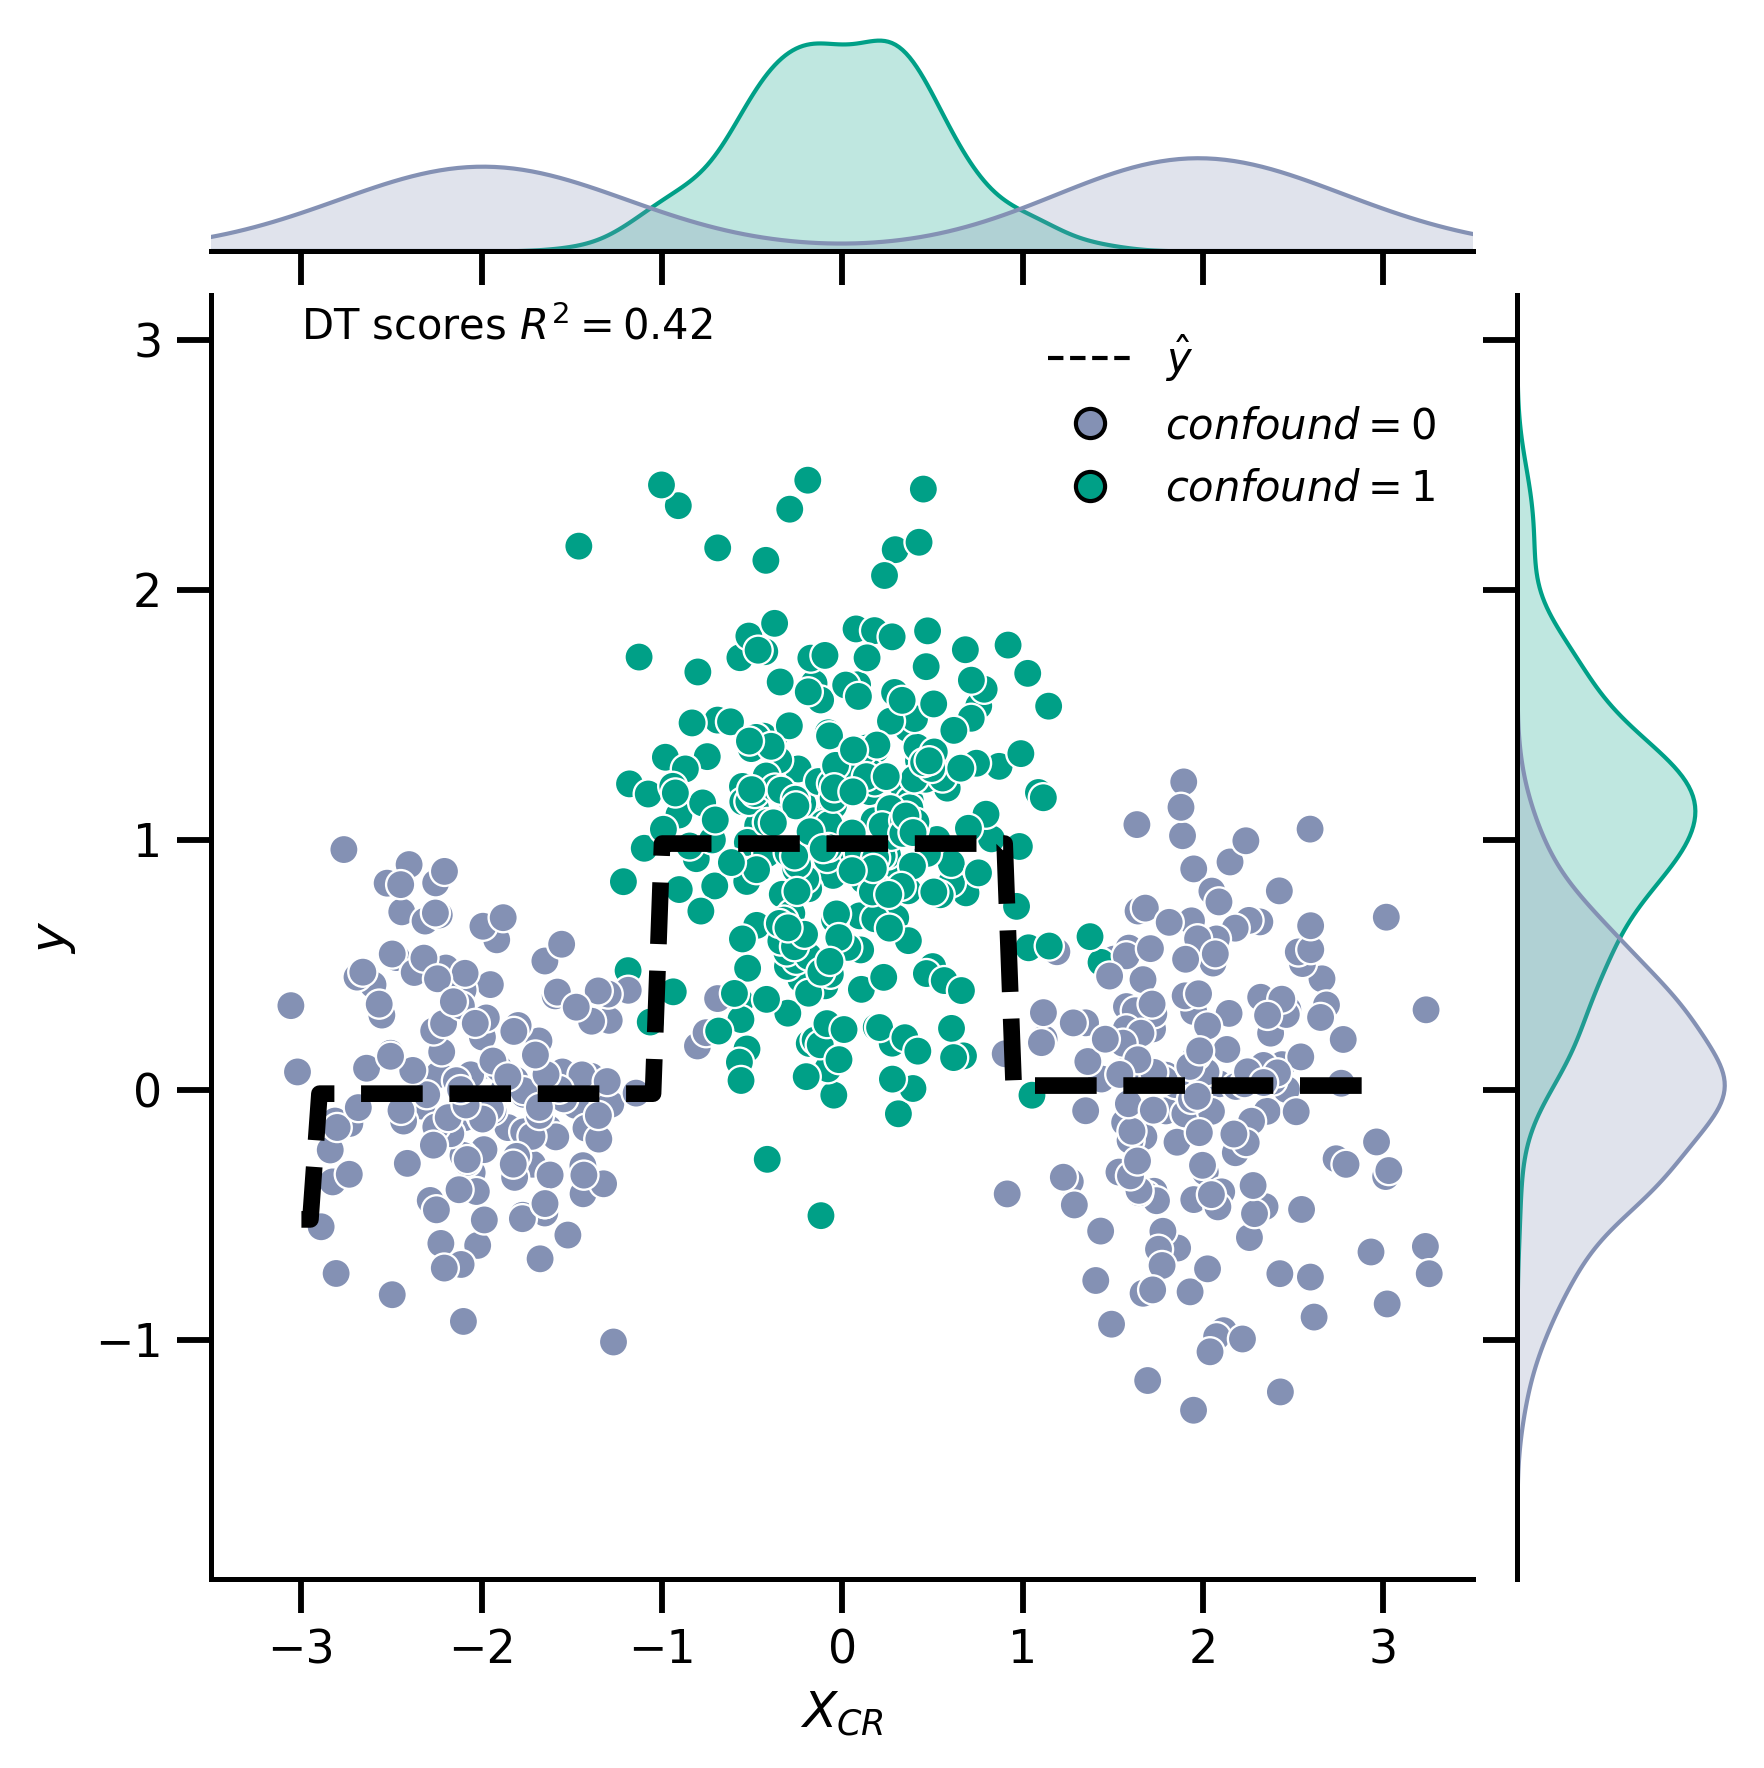

In [8]:
g = sns.jointplot(x="feat_removed", y="target", hue="confound",
                  hue_order=[0, 1],
                  palette=sns.color_palette([purple, green]),
                  data=df_test_plot, legend=False)

X = np.arange(-3, 3, .05)
pred = dt_CR.predict(X.reshape(-1, 1))
data = pd.DataFrame(dict(pred=pred, X=X))

sns.lineplot(x="X", y="pred", ax=g.ax_joint, data=data, lw=4, color="k")


g.ax_joint.set_xlabel("$X_{CR}$")
g.ax_joint.set_ylabel("$y$")
g.ax_joint.set_xlim(-3.5, 3.5)
g.ax_joint.text(-3, 3, f"DT scores $R^2 = {dt_score_CR:.2}$")


handles = [
    Line2D([0], [0], color="k", lw=1, ls="--", label=r"$\hat{y}$"),
    Line2D([0], [0], marker='o', lw=0, color=purple, label='$confound=0$'),
    Line2D([0], [0], marker='o', lw=0, color=green, label='$confound=1$')
]

g.ax_joint.legend(handles=handles)
g.ax_joint.lines[0].set_linestyle("--")
g.savefig(f"{base_save_paper }/dt_sim_confound_removed.svg")

glue("rm", g.fig, display=False)


````{tabbed}  before removal 
```{glue:figure} no_rm
:figwidth: 900px
```


````

````{tabbed}  afer removal 
```{glue:figure} rm
:figwidth: 900px
```
````